In [10]:
import os, sys
sys.path.append('../matplotlib_surface_plotting/')

from matplotlib_surface_plotting import plot_surf
import nibabel as nb
import numpy as np

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import cm

def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = np.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

def normal_vectors(vertices,faces):
    norm = np.zeros( vertices.shape, dtype=vertices.dtype )
    tris = vertices[faces]
    n = np.cross( tris[::,1 ] - tris[::,0]  , tris[::,2 ] - tris[::,0] )
    n=normalize_v3(n)
    return n
#    norm[ faces[:,0] ] += n
#    norm[ faces[:,1] ] += n
#    norm[ faces[:,2] ] += n
 #   return normalize_v3(norm)


def frustum(left, right, bottom, top, znear, zfar):
    M = np.zeros((4, 4), dtype=np.float32)
    M[0, 0] = +2.0 * znear / (right - left)
    M[1, 1] = +2.0 * znear / (top - bottom)
    M[2, 2] = -(zfar + znear) / (zfar - znear)
    M[0, 2] = (right + left) / (right - left)
    M[2, 1] = (top + bottom) / (top - bottom)
    M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
    M[3, 2] = -1.0
    return M

def perspective(fovy, aspect, znear, zfar):
    h = np.tan(0.5*np.radians(fovy)) * znear
    w = h * aspect
    return frustum(-w, w, -h, h, znear, zfar)

def translate(x, y, z):
    return np.array([[1, 0, 0, x], [0, 1, 0, y],
                     [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)

def xrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return np.array([[1, 0,  0, 0], 
                     [0, c, -s, 0],
                     [0, s,  c, 0], 
                     [0, 0,  0, 1]], dtype=float)

def yrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return  np.array([[ c, 0, s, 0], 
                      [ 0, 1, 0, 0],
                      [-s, 0, c, 0], 
                      [ 0, 0, 0, 1]], dtype=float)

def zrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return  np.array([[ c, -s, 0, 0], 
                      [ s, c, 0, 0],
                      [0, 0, 1, 0], 
                      [ 0, 0, 0, 1]], dtype=float)

def shading_intensity(vertices,faces, light = np.array([0,0,1]),shading=0.7):
    """shade calculation based on light source
       default is vertical light.
       shading controls amount of shading.
       Also saturates so top 20 % of vertices all have max intensity."""
    face_normals=normal_vectors(vertices,faces)
    intensity = np.dot(face_normals, light)
    intensity[np.isnan(intensity)]=1
    shading = 0.7    
    #top 20% all become fully coloured
    intensity = (1-shading)+shading*(intensity-np.min(intensity))/((np.percentile(intensity,80)-np.min(intensity)))
    #saturate
    intensity[intensity>1]=1
    return intensity

def f7(seq):
    #returns uniques but in order to retain neighbour triangle relationship
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))];


def get_ring_of_neighbours(island, neighbours, vertex_indices=None, ordered=False):
    """Calculate ring of neighbouring vertices for an island of cortex
    If ordered, then vertices will be returned in connected order"""
    if not vertex_indices:
        vertex_indices=np.arange(len(island))
    if not ordered:

        neighbours_island = neighbours[island]
        unfiltered_neighbours = []
        for n in neighbours_island:
            unfiltered_neighbours.extend(n)
        unique_neighbours = np.setdiff1d(np.unique(unfiltered_neighbours), vertex_indices[island])
        return unique_neighbours

def get_neighbours_from_tris(tris, label=None):
    """Get surface neighbours from tris
        Input: tris
         Returns Nested list. Each list corresponds 
        to the ordered neighbours for the given vertex"""
    n_vert=np.max(tris+1)
    neighbours=[[] for i in range(n_vert)]
    for tri in tris:
        neighbours[tri[0]].extend([tri[1],tri[2]])
        neighbours[tri[2]].extend([tri[0],tri[1]])
        neighbours[tri[1]].extend([tri[2],tri[0]])
    #Get unique neighbours
    for k in range(len(neighbours)):      
        if label is not None:
            neighbours[k] = set(neighbours[k]).intersection(label)
        else :
            neighbours[k]=f7(neighbours[k])
    return np.array(neighbours)

def adjust_colours_pvals(colours, pvals,triangles,mask=None):
    """red ring around clusters and greying out non-significant vertices"""
    if mask is not None:
        verts_masked = mask[triangles].any(axis=1)
        colours[verts_masked,:] = np.array([0.86,0.86,0.86,1])
    neighbours=get_neighbours_from_tris(triangles)
    ring=get_ring_of_neighbours(pvals<0.05,neighbours)
    if len(ring)>0:
        ring_label = np.zeros(len(neighbours)).astype(bool)
        ring_label[ring]=1
        ring=get_ring_of_neighbours(ring_label,neighbours)
        ring_label[ring]=1
        colours[ring_label[triangles].any(axis=1),:] = np.array([1.0,0,0,1])
    grey_out=pvals<0.05
    verts_grey_out= grey_out[triangles].any(axis=1)
    colours[verts_grey_out,:] = (1.5*colours[verts_grey_out] + np.array([0.86,0.86,0.86,1]))/2.5
    return colours

def frontback(T):
    """
    Sort front and back facing triangles
    Parameters:
    -----------
    T : (n,3) array
       Triangles to sort
    Returns:
    --------
    front and back facing triangles as (n1,3) and (n2,3) arrays (n1+n2=n)
    """
    Z = (T[:,1,0]-T[:,0,0])*(T[:,1,1]+T[:,0,1]) + \
        (T[:,2,0]-T[:,1,0])*(T[:,2,1]+T[:,1,1]) + \
        (T[:,0,0]-T[:,2,0])*(T[:,0,1]+T[:,2,1])
    return Z < 0, Z >= 0


def plot_surf(vertices, faces, overlay, rotate=[270,90], cmap='viridis', filename='plot.png', label=False,
             vmax=None, vmin=None, x_rotate=270,z_rotate=0, pvals=None, colorbar=True, title=None, mask=None, base_size=6
            ):
    """plot mesh surface with a given overlay
    vertices - vertex locations
    faces - triangles of vertex indices definings faces
    overlay - array to be plotted
    cmap - matplotlib colormap
    rotate - 270 for lateral on lh, 90 for medial
    """
    vertices=vertices.astype(np.float)
    F=faces.astype(int)
    vertices = (vertices-(vertices.max(0)+vertices.min(0))/2)/max(vertices.max(0)-vertices.min(0))
    if not isinstance(rotate,list):
        rotate=[rotate]
    if not isinstance(overlay,list):
        overlays=[overlay]
    else:
        overlays=overlay
    intensity=shading_intensity(vertices, F, light=np.array([0,0,1]),shading=0.7)
     #make figure dependent on rotations
    
    fig = plt.figure(figsize=(base_size*len(rotate)+colorbar*(base_size-2),(base_size-1)*len(overlays)))
    if title is not None:
        plt.title(title, fontsize=25)
    plt.axis('off')
    for k,overlay in enumerate(overlays):
        #colours smoothed (mean) or median if label
        if label:
            colours = np.median(overlay[F],axis=1)
        else:
            colours = np.mean(overlay[F],axis=1)
        if vmax is not None:
            colours = (colours - vmin)/(vmax-vmin)
            colours = np.clip(colours,0,1)
        else:
            colours = (colours - colours.min())/(colours.max()-colours.min())
            vmax = colours.max()
            vmin = colours.min()
        C = plt.get_cmap(cmap)(colours) 
        if pvals is not None:
            C = adjust_colours_pvals(C,pvals,F,mask)
        C[:,0] *= intensity
        C[:,1] *= intensity
        C[:,2] *= intensity
        for i,view in enumerate(rotate):
            MVP = perspective(25,1,1,100) @ translate(0,0,-3) @ yrotate(view) @ xrotate(x_rotate)
        #translate coordinates based on viewing position
            V = np.c_[vertices, np.ones(len(vertices))]  @ MVP.T
            V /= V[:,3].reshape(-1,1)
            V = V[F]
        #triangle coordinates
            T =  V[:,:,:2]
        #get Z values for ordering triangle plotting
            Z = -V[:,:,2].mean(axis=1)
        #sort the triangles based on their z coordinate. If front/back views then need to sort a different axis
#sort the triangles based on their z coordinate. If front/back views then need to sort a different axis
            front, back = frontback(T)
            T=T[front]
            s_C = C[front]
            Z = Z[front]
            I = np.argsort(Z)
            T, s_C = T[I,:], s_C[I,:]
            ax = fig.add_subplot(len(overlays),len(rotate)+1,2*k+i+1, xlim=[-.9,+.9], ylim=[-.9,+.9],aspect=1, frameon=False,
             xticks=[], yticks=[])
            collection = PolyCollection(T, closed=True, linewidth=0,antialiased=False, facecolor=s_C)
            collection.set_alpha(1)
            ax.add_collection(collection)
            plt.subplots_adjust(left =0 , right =1, top=1, bottom=0,wspace=0, hspace=0)
    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable( cmap=cmap), ticks=[0,0.5, 1],cax = fig.add_axes([0.7, 0.3, 0.03, 0.38]))
        cbar.ax.set_yticklabels([np.round(vmin,decimals=2), np.round(np.mean([vmin,vmax]),decimals=2),
                         np.round(vmax,decimals=2)])
        cbar.ax.tick_params(labelsize=25)
    fig.savefig(filename,bbox_inches = 'tight',pad_inches=0,transparent=True)

In [80]:
surf=nb.load('../data/fs_LR.32k.L.flat.surf.gii')
vertices,faces = surf.darrays[0].data,surf.darrays[1].data

In [81]:
#vertices = np.roll(vertices,1)

In [82]:
vector_file=nb.load('../data/MyelinMap_inflated_vectors.L.func.gii')
vectors=np.array([vector_file.darrays[0].data,
                  vector_file.darrays[1].data,
                  vector_file.darrays[2].data])

In [83]:
# surf=nb.load('../data/fs_LR.32k.L.inflated.surf.gii')
# vertices,faces = surf.darrays[0].data,surf.darrays[1].data

In [84]:
overlay = nb.load('../data/S1200.MyelinMap.L.func.gii').darrays[0].data

/home/kwagstyl/anaconda2/envs/padl/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/kwagstyl/anaconda2/envs/padl/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/kwagstyl/anaconda2/envs/padl/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/kwagstyl/anaconda2/envs/padl/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


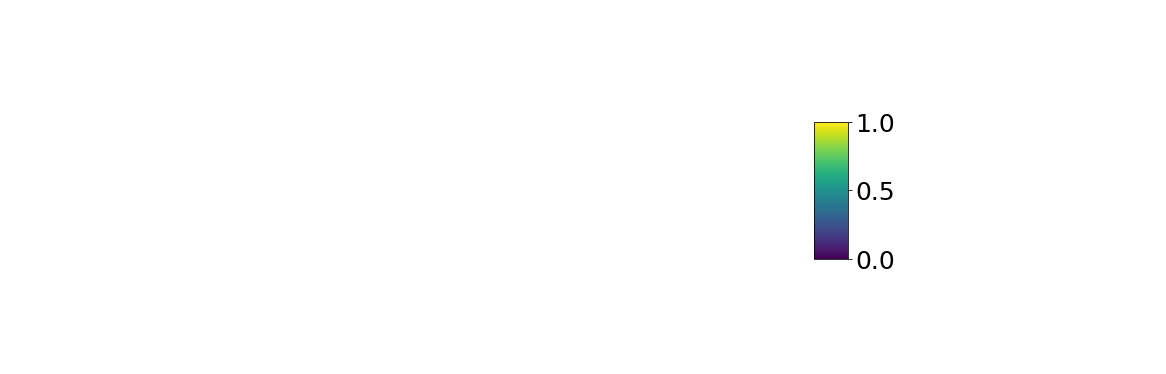

In [87]:
plot_surf(vertices,faces,overlay,x_rotate=270)